# Problem Statement
Customer Behaviour and it’s prediction lies 
at the core of every Business Model. From 
Stock Exchange, e-Commerce and 
Automobile to even Presidential Elections, 
predictions serve a great purpose. Most of 
these predictions are based on the data 
available about a person’s activity either 
online or in-


Recommendation Engines are the much 
needed manifestations of the desired 
Predictability of User Activity. 
Recommendation Engines move one step 
further and not only give information but 
put forth strategies to further increase users 
interaction with the pla

In today’s world OTT platform and Streaming 
Services have taken up a big chunk in the 
Retail and Entertainment industry. 
Organizations like Netflix, Amazon etc. 
analyse User Activity Pattern’s and suggest 
products that better suit the user needs and 
ch

 For the purpose of this Project we will be 
creating one such Recommendation Engine 
from the ground-up, where every single user, 
based on there area of interest and ratings, 
would be recommended a list of movies that 
are best suited for them.oices.tform.person.

## Dataset Information
1. ID–Contains the separate keys for 
customer and movies. 
2. Rating– A section contains the user 
ratings for all the movies. 
movie. 
3. Genre–Highlights the category of the 
4. Movie Name–Name of the movie with 
respect to the movie id.

# Objective 
1. Find out the list of most popular and liked genre
 2. Create Model that finds the best suited Movie for one 
user in every genre.
 3. Find what Genre Movies have received the best and 
worst ratings based on User Rating.

### Project Setup and Imports

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
import pickle

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### Data Acquisition and Preparation

In [8]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [9]:
display(movies_df.head())
display(ratings_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


### Data Quality Check

In [11]:
print("Movies Data Info:")
print(movies_df.info())
print("\nRatings Data Info:")
print(ratings_df.info())

Movies Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Ratings Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 32.0 MB
None


#### Data Cleaning

In [13]:
print("\nMovies Missing Values:")
print(movies_df.isnull().sum())
print("\nRatings Missing Values:")
print(ratings_df.isnull().sum())


Movies Missing Values:
movieId    0
title      0
genres     0
dtype: int64

Ratings Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


#### Duplicate Removal

In [15]:
print(movies_df.duplicated().sum())
print(ratings_df.duplicated().sum())

0
0


In [16]:
movies_df.drop_duplicates(inplace=True)
ratings_df.drop_duplicates(inplace=True)

#### Categorical Data Handling

In [18]:
original_movies_df = movies_df.copy()
original_ratings_df = ratings_df.copy()

In [19]:
movies_df['genres']

0        Adventure|Animation|Children|Comedy|Fantasy
1                         Adventure|Children|Fantasy
2                                     Comedy|Romance
3                               Comedy|Drama|Romance
4                                             Comedy
                            ...                     
27273                                         Comedy
27274                                         Comedy
27275                                      Adventure
27276                             (no genres listed)
27277                       Adventure|Fantasy|Horror
Name: genres, Length: 27278, dtype: object

In [20]:
movies_df['genres'].str.split('|')

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
27273                                             [Comedy]
27274                                             [Comedy]
27275                                          [Adventure]
27276                                 [(no genres listed)]
27277                         [Adventure, Fantasy, Horror]
Name: genres, Length: 27278, dtype: object

In [21]:
genres = movies_df['genres'].str.split('|').explode('genres')
genres = set(genres)
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [22]:
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df_expanded = movies_df.explode('genres')
movies_df_expanded

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
...,...,...,...
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure
27277,131262,Innocence (2014),Fantasy


In [23]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [24]:
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')
movies_df['year'].isnull().sum()

22

In [25]:
movies_df['year'].unique(), movies_df['year'].nunique()

(array([1995., 1994., 1996., 1976., 1992., 1988., 1967., 1993., 1964.,
        1977., 1965., 1982., 1985., 1990., 1991., 1989., 1937., 1940.,
        1969., 1981., 1973., 1970., 1960., 1955., 1959., 1968., 1980.,
        1975., 1986., 1948., 1943., 1950., 1946., 1987., 1997., 1974.,
        1956., 1958., 1949., 1972., 1998., 1933., 1952., 1951., 1957.,
        1961., 1954., 1934., 1944., 1963., 1942., 1941., 1953., 1939.,
        1947., 1945., 1938., 1935., 1936., 1926., 1932., 1979., 1971.,
        1978., 1966., 1962., 1983., 1984., 1931., 1922., 1999., 1927.,
        1929., 1930., 1928., 1925., 1914., 2000., 1919., 1923., 1920.,
        1918., 1921., 2001., 1924., 2002., 2003., 1915., 2004., 1916.,
        1917., 2005., 2006., 1902.,   nan, 1903., 2007., 2008., 2009.,
        1912., 2010., 1913., 2011., 1898., 1899., 1894., 2012., 1909.,
        1910., 1901., 1893., 2013., 1896., 2014., 1895., 2015., 1900.,
        1905., 1891.]),
 118)

#### Data type conversion

In [27]:
movies_df.dtypes, ratings_df.dtypes

(movieId      int64
 title       object
 genres      object
 year       float64
 dtype: object,
 userId         int64
 movieId        int64
 rating       float64
 timestamp      int64
 dtype: object)

In [28]:
print('\nMovie df memory: ',movies_df.memory_usage(deep = True).sum())
print('\nRating df memory: ',ratings_df.memory_usage(deep = True).sum())
movies_df[movies_df.select_dtypes('int').columns] = movies_df.select_dtypes('int').astype('int32')

if 'title' in movies_df.columns:
    movies_df['title'] = movies_df['title'].astype('category')

if 'year' in movies_df.columns: 
    movies_df['year'] = pd.to_datetime(movies_df['year'], errors='coerce')

ratings_df[ratings_df.select_dtypes('int').columns] = ratings_df.select_dtypes('int').astype('int32')

ratings_df[ratings_df.select_dtypes('float').columns] = ratings_df.select_dtypes('float').astype('float32')
print('\nMovie df memory: ',movies_df.memory_usage(deep = True).sum())
print('\nRating df memory: ',ratings_df.memory_usage(deep = True).sum(),'\n')
print(movies_df.dtypes)
print(ratings_df.dtypes)


Movie df memory:  7225389

Rating df memory:  33554532

Movie df memory:  8226456

Rating df memory:  16777332 

movieId             int32
title            category
genres             object
year       datetime64[ns]
dtype: object
userId         int32
movieId        int32
rating       float32
timestamp      int32
dtype: object


### Exploratory Data Analysis (EDA)

In [30]:
total_movie_count = movies_df['movieId'].nunique()
print(f"Total number of movies that are present are: {total_movie_count}")

Total number of movies that are present are: 27278


In [31]:
customer_count = ratings_df['userId'].nunique()
print(f"Total Unique Customer in the dataset: {customer_count}")

Total Unique Customer in the dataset: 7120


In [32]:
ratings_df['rating'].value_counts()

rating
4.0    295135
3.0    226202
5.0    152562
3.5    112926
4.5     79848
2.0     74706
2.5     44791
1.0     35144
1.5     14029
0.5     13232
Name: count, dtype: int64

In [33]:
print('\n Movies are between the year: ',movies_df['year'].dt.year.min(), ' to ',movies_df['year'].dt.year.max(),'\n')


 Movies are between the year:  1970.0  to  1970.0 



In [34]:
rated_movie_list = ratings_df.groupby("movieId")["rating"].agg(["count"])
# movieId	rating
rated_movie_list

,count
movieId,
1,2569
2,1155
3,685
4,138
5,657
...,...
130073,1
130219,1
130462,1


In [35]:
rated_movie_list=rated_movie_list.reset_index()

In [36]:
rated_movie_list = pd.merge(rated_movie_list,movies_df,on='movieId')
most_rated_top10 = rated_movie_list.nlargest(10,columns='count')
most_rated_top10

,movieId,count,title,genres,year
290,296,3498,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1970-01-01 00:00:00.000001994
349,356,3476,Forrest Gump (1994),"[Comedy, Drama, Romance, War]",1970-01-01 00:00:00.000001994
581,593,3247,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1970-01-01 00:00:00.000001991
312,318,3216,"Shawshank Redemption, The (1994)","[Crime, Drama]",1970-01-01 00:00:00.000001994
470,480,3129,Jurassic Park (1993),"[Action, Adventure, Sci-Fi, Thriller]",1970-01-01 00:00:00.000001993
254,260,2874,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",1970-01-01 00:00:00.000001977
107,110,2799,Braveheart (1995),"[Action, Drama, War]",1970-01-01 00:00:00.000001995
577,589,2711,Terminator 2: Judgment Day (1991),"[Action, Sci-Fi]",1970-01-01 00:00:00.000001991
2422,2571,2705,"Matrix, The (1999)","[Action, Sci-Fi, Thriller]",1970-01-01 00:00:00.000001999
517,527,2598,Schindler's List (1993),"[Drama, War]",1970-01-01 00:00:00.000001993


#### Statistical Understanding

In [39]:
print("\nMovies Summary:")
display(movies_df.describe(include='all').round(3).T)
print("\nRatings Summary:")
display(ratings_df.describe().round(3).T)


Movies Summary:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
movieId,27278.0,NaN,NaN,NaN,59855.481,1.0,6931.25,68068.0,100293.25,131262.0,44429.315
title,27278,27262,Darling (2007),2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,27278,1342,[Drama],4520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,27256,NaN,NaN,NaN,1970-01-01 00:00:00.000001989,1970-01-01 00:00:00.000001891,1970-01-01 00:00:00.000001976,1970-01-01 00:00:00.000001998,1970-01-01 00:00:00.000002008,1970-01-01 00:00:00.000002015,NaN



Ratings Summary:


,count,mean,std,min,25%,50%,75%,max
userId,1048575.0,3.527086e+03,2.018424e+03,1.0,1813.0,3.540000e+03,5.233000e+03,7.120000e+03
movieId,1048575.0,8.648988e+03,1.910014e+04,1.0,903.0,2.143000e+03,4.641000e+03,1.306420e+05
rating,1048575.0,3.529000e+00,1.052000e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,1048575.0,1.096036e+09,1.594899e+08,825499934.0,965838177.0,1.099263e+09,1.217407e+09,1.427764e+09


#### Univariate Analysis


Unique Movie Genres:


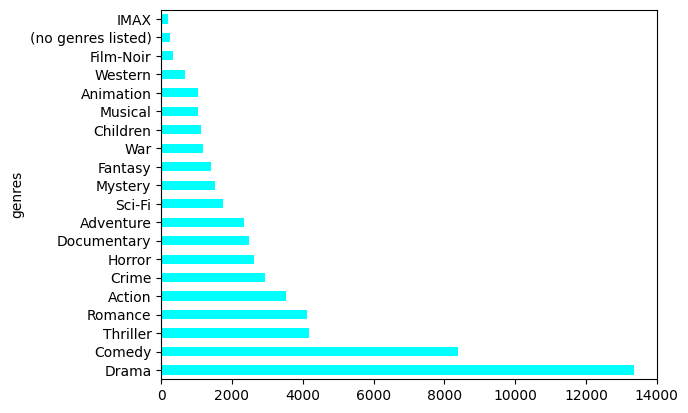

In [41]:
print("\nUnique Movie Genres:")
movies_df_expanded['genres'].value_counts().plot(kind='barh',color='cyan')
plt.show()


Rating Distribution:

Total ratings:  1048575


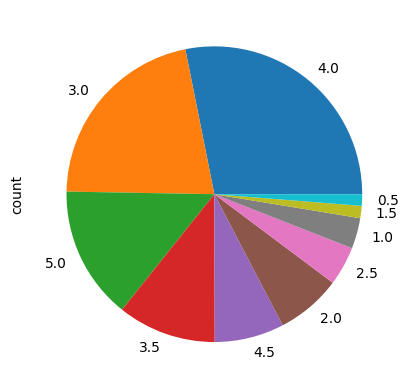

In [42]:
print("\nRating Distribution:")
print("\nTotal ratings: ",ratings_df['rating'].count())
ratings_df['rating'].value_counts().plot(kind='pie')
plt.show()

#### Bivariate Analysis

In [44]:
print("\nAverage Rating per Movie:")
avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
print(avg_ratings.sort_values(ascending=False).head())


Average Rating per Movie:
movieId
95218    5.0
1706     5.0
7330     5.0
134      5.0
60227    5.0
Name: rating, dtype: float32


#### Data Transformation

In [46]:
movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
27273    2007
27274    2002
27275    2014
27276    2001
27277    2014
Name: title, Length: 27278, dtype: object

### Model Selection and Metric Evaluation

In [49]:
# Using Surprise Library for Collaborative Filtering

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# 3.1. Model Selection: SVD (Matrix Factorization)
svd = SVD()

#### Cross-Validation

In [51]:
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8350  0.8322  0.8343  0.8342  0.8305  0.8332  0.0017  
MAE (testset)     0.6394  0.6361  0.6382  0.6387  0.6348  0.6374  0.0017  
Fit time          13.08   13.57   12.38   12.11   12.64   12.75   0.52    
Test time         1.63    4.42    2.27    2.03    2.04    2.48    0.99    


#### Hyperparameter Tuning

In [53]:
param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [20, 30], 'lr_all': [0.005, 0.01]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print("\nBest RMSE:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])


Best RMSE: 0.8429666626449407
Best Parameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005}


#### Best Parameter Selection

In [55]:
best_params = gs.best_params['rmse']

### Best Model Creation and Training

In [57]:
best_svd = SVD(**best_params)
trainset = data.build_full_trainset()
best_svd.fit(trainset)

### Model Persistence (Serialization)

In [59]:
pickle.dump(best_svd, open('recommendation_model.pkl', 'wb'))

### Insight Aggregation and Interpretation

In [61]:
def get_top_n_recommendations(user_id, ratings_df, movies_df, model_path='recommendation_model.pkl', n=10):
    """Get top n movie recommendations for a user, loading the model from a pickle file."""
    try:
        with open(model_path, 'rb') as file:
            best_svd = pickle.load(file)
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    movie_ids = ratings_df['movieId'].unique()
    rated_movie_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    unrated_movie_ids = [movie_id for movie_id in movie_ids if movie_id not in rated_movie_ids]

    predictions = [best_svd.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_n_movie_ids = [prediction.iid for prediction in predictions[:n]]
    top_n_movies = movies_df[movies_df['movieId'].isin(top_n_movie_ids)]
    return top_n_movies[['movieId', 'title']]

In [62]:
user_id_to_recommend = int(input('Enter User ID'))#1
top_recommendations = get_top_n_recommendations(user_id_to_recommend, ratings_df, movies_df)

if top_recommendations is not None:
    print("\nTop Recommendations for User", user_id_to_recommend, ":\n", top_recommendations)
else:
    print("\nNo Recommendations for User")

Enter User ID 1



Top Recommendations for User 1 :
        movieId                                              title
661        670             World of Apu, The (Apur Sansar) (1959)
2849      2935                               Lady Eve, The (1941)
5473      5570                              Thesis (Tesis) (1996)
6172      6271          Day for Night (La Nuit Américaine) (1973)
6859      6971                           Europa (Zentropa) (1991)
6873      6985  Passion of Joan of Arc, The (Passion de Jeanne...
7464      7767     Best of Youth, The (La meglio gioventù) (2003)
8937     26587                    Decalogue, The (Dekalog) (1989)
18528    92259                                Intouchables (2011)
18990    94466                                Black Mirror (2011)


### Inference

## 1. Find out the list of most popular and liked genre


In [65]:
print("\nList of Most Popular Movie Genres:")
movies_df_expanded['genres'].value_counts()


List of Most Popular Movie Genres:


genres
Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
Name: count, dtype: int64

In [66]:
print("\nList of Most Liked Movie Genres:")
merged_data = pd.merge(ratings_df, movies_df_expanded, on='movieId')
genre_ratings = merged_data.groupby('genres')['rating'].agg(['mean', 'count'])
genre_ratings.columns = ['Average Rating', 'Rating Count']
genre_ratings = genre_ratings.reset_index()
genre_ratings.sort_values(['Average Rating','Rating Count'], ascending=False).head(10)


List of Most Liked Movie Genres:


,genres,Average Rating,Rating Count
10,Film-Noir,3.956143,11241
18,War,3.821342,54347
7,Documentary,3.758738,12675
6,Crime,3.683701,171866
8,Drama,3.678378,461704
14,Mystery,3.665257,82157
12,IMAX,3.656697,25527
3,Animation,3.608345,59117
19,Western,3.573439,22488
13,Musical,3.550363,45788


## 2. Create Model that finds the best suited Movie for one user in every genre.


In [85]:
model_path='recommendation_model.pkl'
try:
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found.")
    None
except Exception as e:
    print(f"Error loading model: {e}")
    None

In [86]:
genre_map = movies_df_expanded.set_index('movieId')['genres'].to_dict()
all_movies = movies_df[['movieId', 'title']]
def get_genre_recommendations(user_id, n=5):
    # Get all movies not rated by user
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
    unrated_movies = all_movies[~all_movies['movieId'].isin(rated_movies)]
    
    # Predict ratings
    predictions = []
    for movie_id in unrated_movies['movieId']:
        pred = model.predict(user_id, movie_id)
        predictions.append({
            'movieId': movie_id,
            'pred_rating': pred.est,
            'genres': genre_map.get(movie_id, [])
        })
    
    # Create recommendations per genre
    pred_df = pd.DataFrame(predictions).explode('genres')
    best_per_genre = pred_df.groupby('genres').apply(
        lambda x: x.nlargest(1, 'pred_rating')
    ).reset_index(drop=True)
    
    return best_per_genre[['genres', 'movieId', 'pred_rating']]

In [91]:
print('Welcome to movie recommender!')
user_id = int(input('Provide the User ID: '))
recommendations = get_genre_recommendations(user_id)
if recommendations is not None:
    print(f"\nRecommended movies per genre for user {user_id}:")
    print(recommendations.sort_values('pred_rating',ascending = False))
    print('\nEnjoy your movies!!!')
else:
    print(f"\nNo Recommendations for User {user_id}")
    print('Try Again!')


Welcome to movie recommender!


Provide the User ID:  1



Recommended movies per genre for user 1:
                genres  movieId  pred_rating
15             Romance     6271     4.615749
16              Sci-Fi    94466     4.603606
17            Thriller     6971     4.569341
8                Drama     6985     4.553010
18                 War      527     4.487522
9              Fantasy    27251     4.448299
12                IMAX    89745     4.439915
13             Musical     2859     4.413657
10           Film-Noir     4432     4.408849
7          Documentary      116     4.407747
5               Comedy   108583     4.397157
14             Mystery      824     4.351238
19             Western     6422     4.302792
11              Horror    73759     4.281594
3            Animation    99813     4.255601
6                Crime      950     4.245997
1               Action     7899     4.200499
2            Adventure     5244     4.128175
4             Children   112006     4.040750
0   (no genres listed)   126560     3.737518

Enjoy your m

C:\Users\Avinash Mishra\AppData\Local\Temp\ipykernel_21496\1061947266.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_genre = pred_df.groupby('genres').apply(


## 3. Find what Genre Movies have received the best and worst ratings based on User Rating.

In [93]:
print("\nBest Rated Genres:\n")
display(genre_ratings.sort_values('Average Rating', ascending=False).head(5))
print("\nWorst Rated Genres:\n")
display(genre_ratings.sort_values('Average Rating').head(5))


Best Rated Genres:



,genres,Average Rating,Rating Count
10,Film-Noir,3.956143,11241
18,War,3.821342,54347
7,Documentary,3.758738,12675
6,Crime,3.683701,171866
8,Drama,3.678378,461704



Worst Rated Genres:



,genres,Average Rating,Rating Count
0,(no genres listed),3.071429,7
11,Horror,3.262442,77518
4,Children,3.404140,87101
5,Comedy,3.432287,395994
16,Sci-Fi,3.434519,166024
